# Proyecto Final: Imputaciones.

## Datos Faltantes de las Estaciones de Monitoreo

Algunso datos faltantes son causados por mantenimiento del equipo. Pero pudiéramos enriquecer la información con los datos de estaciones cercanas. Para ello vamos a evaluar las imputaciones.

In [1]:
import os, gzip, json, re, stan, dplython, asyncio, nest_asyncio
#nest_asyncio.apply()
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
from dplython import (DplyFrame, X, diamonds, select, sift,
  sample_n, sample_frac, head, arrange, mutate, group_by,
  summarize, DelayFunction, dfilter)
import seaborn as sns
from plotnine import *
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             r2_score,
                             mean_absolute_error)
import pandas as pd
from IPython.display import display, Markdown

/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/jaa6766/.conda/envs/cuda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
dsinaica = DplyFrame(pd.read_pickle("data/sinaica/dsinaica.pickle"))
dsinaica

,Fecha,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2,FES Acatlán_CO,...,Miguel Hidalgo_O3,Miguel Hidalgo_SO2,Tlalnepantla_CO,Tlalnepantla_NO,Tlalnepantla_NO2,Tlalnepantla_NOx,Tlalnepantla_O3,Tlalnepantla_PM10,Tlalnepantla_PM2.5,Tlalnepantla_SO2
0,2021-01-01 00:00:00,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002,0.4,...,0.009,0.003,0.6,NaN,0.030,0.034,0.012,37.0,19.0,0.002
1,2021-01-01 01:00:00,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002,0.6,...,0.006,0.003,0.6,NaN,0.026,0.029,0.013,42.0,29.0,0.003
2,2021-01-01 02:00:00,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001,0.9,...,0.003,0.002,0.7,NaN,0.032,0.036,0.006,58.0,43.0,0.002
3,2021-01-01 03:00:00,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001,0.8,...,0.004,0.002,0.7,NaN,0.033,0.039,0.004,59.0,41.0,0.002
4,2021-01-01 04:00:00,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001,1.0,...,0.006,0.002,0.7,NaN,0.032,0.038,0.004,64.0,46.0,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2021-04-01 19:00:00,0.4,0.003,0.011,0.013,0.016,69.0,7.0,0.001,0.3,...,0.023,0.000,0.3,0.009,0.017,0.025,0.017,52.0,24.0,0.003
2167,2021-04-01 20:00:00,0.4,0.002,0.011,0.012,0.018,71.0,9.0,0.001,0.2,...,0.024,0.000,0.4,0.004,0.015,0.019,0.020,22.0,10.0,0.005
2168,2021-04-01 21:00:00,0.4,0.002,0.013,0.015,0.016,37.0,9.0,0.001,0.2,...,0.023,0.000,0.3,0.002,0.014,0.017,0.021,21.0,14.0,0.002
2169,2021-04-01 22:00:00,0.4,0.002,0.019,0.021,0.012,19.0,0.0,0.001,0.1,...,0.027,0.000,0.3,0.002,0.011,0.013,0.022,11.0,7.0,0.001


In [5]:
dsinaica[dsinaica.isna().any(axis=1)]

,Fecha,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2,FES Acatlán_CO,...,Miguel Hidalgo_O3,Miguel Hidalgo_SO2,Tlalnepantla_CO,Tlalnepantla_NO,Tlalnepantla_NO2,Tlalnepantla_NOx,Tlalnepantla_O3,Tlalnepantla_PM10,Tlalnepantla_PM2.5,Tlalnepantla_SO2
0,2021-01-01 00:00:00,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002,0.4,...,0.009,0.003,0.6,NaN,0.030,0.034,0.012,37.0,19.0,0.002
1,2021-01-01 01:00:00,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002,0.6,...,0.006,0.003,0.6,NaN,0.026,0.029,0.013,42.0,29.0,0.003
2,2021-01-01 02:00:00,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001,0.9,...,0.003,0.002,0.7,NaN,0.032,0.036,0.006,58.0,43.0,0.002
3,2021-01-01 03:00:00,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001,0.8,...,0.004,0.002,0.7,NaN,0.033,0.039,0.004,59.0,41.0,0.002
4,2021-01-01 04:00:00,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001,1.0,...,0.006,0.002,0.7,NaN,0.032,0.038,0.004,64.0,46.0,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2021-03-31 13:00:00,0.4,0.004,0.017,0.020,0.053,96.0,23.0,0.002,NaN,...,0.075,0.001,0.5,0.010,0.018,0.028,0.062,64.0,37.0,0.002
2144,2021-03-31 21:00:00,0.4,0.002,0.019,0.021,0.021,42.0,13.0,0.001,0.3,...,NaN,NaN,0.4,0.004,0.018,0.022,0.025,112.0,43.0,0.003
2146,2021-03-31 23:00:00,0.8,0.013,0.063,0.076,0.007,69.0,26.0,0.002,0.6,...,0.043,0.001,0.6,0.002,0.042,0.044,0.023,41.0,24.0,0.002
2164,2021-04-01 17:00:00,0.4,0.003,0.009,0.012,0.022,42.0,14.0,0.001,0.2,...,0.031,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Datos Faltantes en Estación Camarones 

Observamos que en la estación Camarones, que es la más cercana, todos los indicadores tienen valores faltantes.

In [13]:
camarones = dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones")
camarones

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
0,0.6,0.006,0.029,0.034,0.011,NaN,NaN,0.002
1,1.0,0.021,0.038,0.059,0.002,NaN,NaN,0.002
2,0.8,0.013,0.035,0.049,0.003,NaN,NaN,0.001
3,1.0,0.031,0.034,0.065,0.002,NaN,NaN,0.001
4,0.6,0.005,0.029,0.034,0.005,NaN,NaN,0.001
...,...,...,...,...,...,...,...,...
2027,NaN,NaN,NaN,NaN,NaN,85.0,26.0,NaN
2028,NaN,NaN,NaN,NaN,NaN,67.0,22.0,NaN
2029,NaN,NaN,NaN,NaN,NaN,63.0,28.0,NaN
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
display(Markdown(f"De ahí que tengamos la idea de no perder una porción considerable: " +
                 f'{100*dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones").shape[0]/dsinaica.shape[0]:.2f}%' +
                 f' mediante imputación. Vamos a evaluar los varios métodos con el fin de imputar de la manera más acertada.'
                ))

De ahí que tengamos la idea de no perder una porción considerable: 28.14% mediante imputación. Vamos a evaluar los varios métodos con el fin de imputar de la manera más acertada.

### Observaciones Completas en Estación Camarones

In [15]:
dsinaica[~dsinaica.filter(like="Camarones").isna().any(axis=1)].filter(like="Camarones")

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
479,0.5,0.021,0.024,0.046,0.002,30.0,14.0,0.008
480,0.6,0.017,0.023,0.039,0.002,28.0,16.0,0.006
481,0.5,0.023,0.022,0.046,0.002,38.0,26.0,0.005
482,0.6,0.030,0.021,0.051,0.002,35.0,21.0,0.003
483,0.8,0.057,0.022,0.079,0.002,26.0,12.0,0.003
...,...,...,...,...,...,...,...,...
2166,0.4,0.003,0.011,0.013,0.016,69.0,7.0,0.001
2167,0.4,0.002,0.011,0.012,0.018,71.0,9.0,0.001
2168,0.4,0.002,0.013,0.015,0.016,37.0,9.0,0.001
2169,0.4,0.002,0.019,0.021,0.012,19.0,0.0,0.001


### Separación en Sets de Pruebas y Entrenamiento

In [16]:
camarones_full = dsinaica[~dsinaica.filter(like="Camarones").isna().any(axis=1)]
camarones_train, camarones_test = train_test_split(camarones_full,
                                                   test_size=0.3, random_state=175904,
                                                   shuffle=False
                                                  )
camarones_val = dsinaica[dsinaica.filter(like="Camarones").isna().any(axis=1)]
display(Markdown(f"* Observaciones completas: {camarones_full.shape[0]} (100%)."))
display(Markdown(f">* Observaciones completas en el set de entrenamiento: {camarones_train.shape[0]} (~70%)."))
display(Markdown(f">* Observaciones completas en el set de pruebas: {camarones_test.shape[0]} (~30%)."))
display(Markdown(f"* Observaciones incompletas: {camarones_val.shape[0]}."))

* Observaciones completas: 1560 (100%).

>* Observaciones completas en el set de entrenamiento: 1092 (~70%).

>* Observaciones completas en el set de pruebas: 468 (~30%).

* Observaciones incompletas: 611.

### Distribución de Datos

#### PM10

Estas son las estaciones que miden el contaminante PM 10.

In [17]:
dsinaica[~dsinaica.filter(like="PM10").isna().any(axis=1)].filter(like="PM10")

,Camarones_PM10,FES Acatlán_PM10,Gustavo A. Madero_PM10,Merced_PM10,Tlalnepantla_PM10
479,30.0,15.0,33.0,34.0,32.0
480,28.0,11.0,32.0,29.0,24.0
481,38.0,15.0,28.0,33.0,41.0
482,35.0,15.0,25.0,32.0,20.0
483,26.0,15.0,31.0,27.0,19.0
...,...,...,...,...,...
2165,71.0,178.0,69.0,49.0,90.0
2166,69.0,162.0,33.0,36.0,52.0
2167,71.0,49.0,32.0,24.0,22.0
2169,19.0,14.0,19.0,21.0,11.0


In [18]:
def describe_with_na(dataframe):
    dna = dataframe.isna()
    dna = dna.astype('int').sum()
    dna.name = "NAs"
    
    dataframe = dataframe.describe()
    dataframe = dataframe.append(dna)
    dataframe = dataframe.T
    dataframe.insert(0, "Estacion", dataframe.index)
    return dataframe
describe_with_na(camarones_train.filter(regex=r"PM10", axis=1))


,Estacion,count,mean,std,min,25%,50%,75%,max,NAs
Camarones_PM10,Camarones_PM10,1092.0,58.029304,27.969164,0.0,41.0,55.0,71.0,437.0,0.0
FES Acatlán_PM10,FES Acatlán_PM10,1007.0,48.321748,32.849493,0.0,28.0,42.0,61.0,388.0,85.0
Gustavo A. Madero_PM10,Gustavo A. Madero_PM10,1029.0,52.945578,26.732006,0.0,34.0,50.0,67.0,352.0,63.0
Merced_PM10,Merced_PM10,1084.0,56.695572,21.527185,5.0,42.0,55.0,69.0,184.0,8.0
Tlalnepantla_PM10,Tlalnepantla_PM10,1034.0,52.277563,29.432439,0.0,36.0,48.0,63.0,416.0,58.0


In [19]:
describe_with_na(dsinaica.filter(regex=r"Camarones", axis=1))

,Estacion,count,mean,std,min,25%,50%,75%,max,NAs
Camarones_CO,Camarones_CO,2050.0,0.771805,0.430131,0.000,0.500,0.700,1.000,3.200,121.0
Camarones_NO,Camarones_NO,2042.0,0.025181,0.045487,0.000,0.002,0.006,0.026,0.432,129.0
Camarones_NO2,Camarones_NO2,2042.0,0.031787,0.015682,0.003,0.020,0.031,0.042,0.111,129.0
Camarones_NOx,Camarones_NOx,2042.0,0.056961,0.054418,0.004,0.022,0.039,0.071,0.499,129.0
Camarones_O3,Camarones_O3,2042.0,0.025693,0.024107,0.001,0.004,0.018,0.042,0.103,129.0
Camarones_PM10,Camarones_PM10,1616.0,58.066213,26.906212,0.000,41.000,55.000,71.000,437.000,555.0
Camarones_PM2.5,Camarones_PM2.5,1604.0,25.158978,12.946419,0.000,16.000,24.000,33.000,126.000,567.0
Camarones_SO2,Camarones_SO2,2042.0,0.006598,0.013053,0.000,0.002,0.003,0.005,0.162,129.0


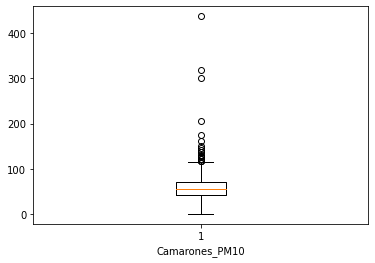

In [20]:
contaminante = "Camarones_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

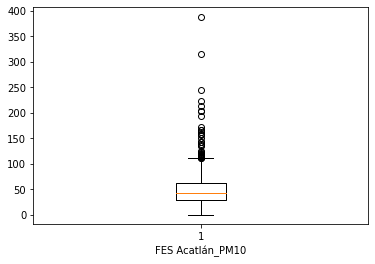

In [21]:
contaminante = "FES Acatlán_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

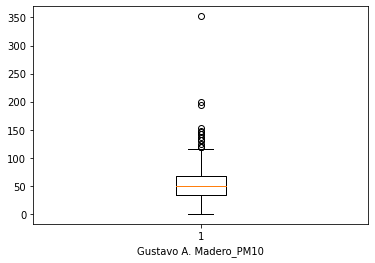

In [22]:
contaminante = "Gustavo A. Madero_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

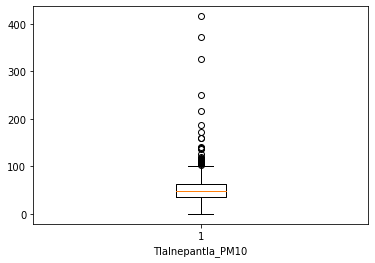

In [23]:
contaminante = "Tlalnepantla_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

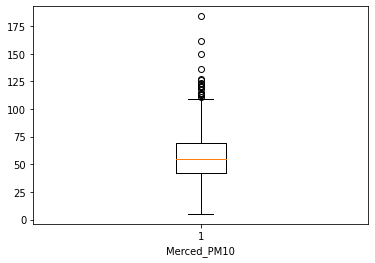

In [24]:
contaminante = "Merced_PM10"
plt.boxplot(x=camarones_train[~camarones_train.filter(regex=contaminante, axis=1).isna().any(axis=1)][contaminante])
plt.xlabel(contaminante)
plt.show()

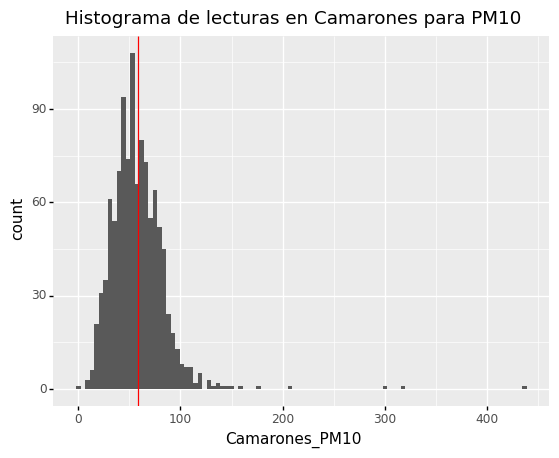

<ggplot: (8752799553353)>

In [163]:
(
    ggplot(camarones_train[["Camarones_PM10"]]) +
    geom_histogram(aes(x="Camarones_PM10"), bins=100) +
    geom_vline(aes(xintercept=camarones_train["Camarones_PM10"].mean()), 
                   color="red") +
    labs(title="Histograma de lecturas en Camarones para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 63 rows containing non-finite values.


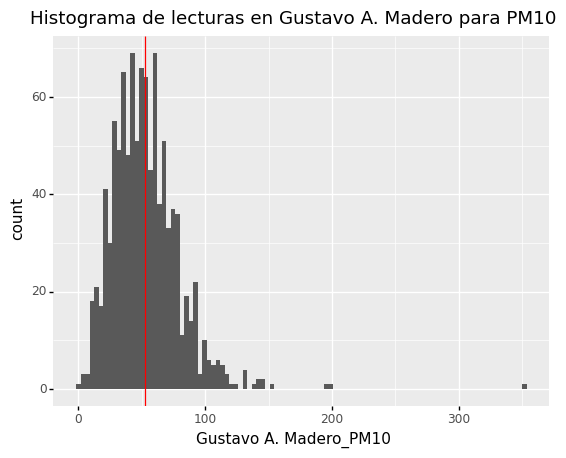

<ggplot: (8752799647057)>

In [162]:
(
    ggplot(camarones_train[["Gustavo A. Madero_PM10"]]) +
    geom_histogram(aes(x="Gustavo A. Madero_PM10"), bins=100) +
    geom_vline(aes(xintercept=camarones_train["Gustavo A. Madero_PM10"].mean()), 
                   color="red") +
    labs(title="Histograma de lecturas en Gustavo A. Madero para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.


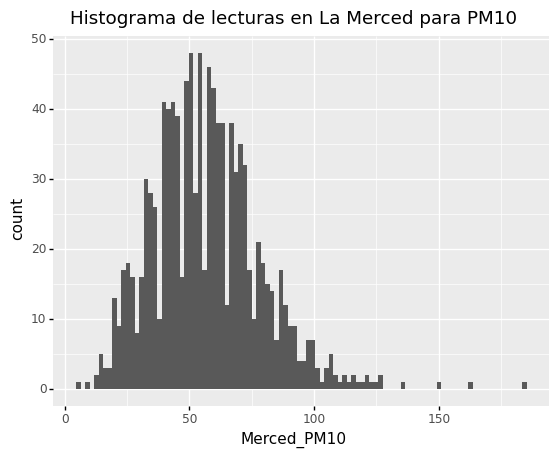

<ggplot: (8752922953057)>

In [27]:
(
    ggplot(camarones_train[["Merced_PM10"]]) +
    geom_histogram(aes(x="Merced_PM10"), bins=100) +
    labs(title="Histograma de lecturas en La Merced para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 85 rows containing non-finite values.


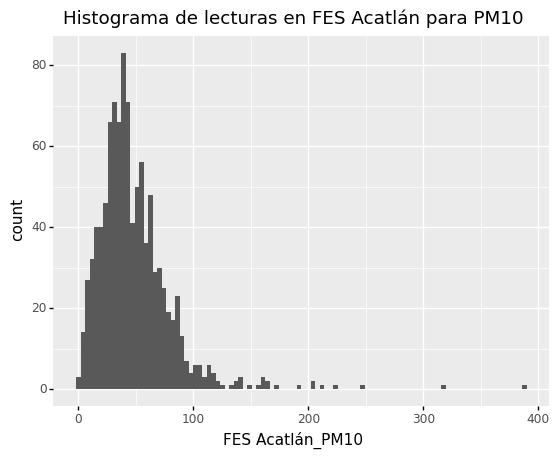

<ggplot: (8752922941465)>

In [28]:
(
    ggplot(camarones_train[["FES Acatlán_PM10"]]) +
    geom_histogram(aes(x="FES Acatlán_PM10"), bins=100) +
    labs(title="Histograma de lecturas en FES Acatlán para PM10")
)

/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 58 rows containing non-finite values.


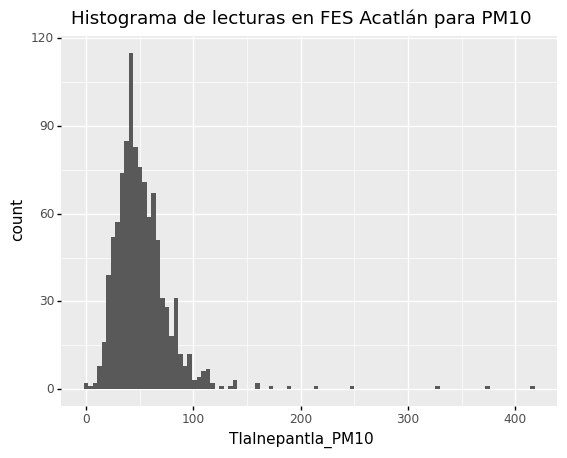

<ggplot: (8752922890993)>

In [29]:
(
    ggplot(camarones_train[["Tlalnepantla_PM10"]]) +
    geom_histogram(aes(x="Tlalnepantla_PM10"), bins=100) +
    labs(title="Histograma de lecturas en FES Acatlán para PM10")
)

In [237]:
import numpy as np
import scipy.stats as st


#data = np.random.random(10000)
distributions = [st.laplace, st.norm, st.laplace, st.t, st.norm, st.cauchy, st.beta]

def best_fit(data, distributions = distributions):
    mles = []
    for distribution in distributions:
        pars = distribution.fit(data)
        mle = distribution.nnlf(pars, data)
        mles.append(mle)

    results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]
    best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]
    print('Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1]))

best_fit(Y_train, )

Best fit reached using beta, MLE value: 4038.7908140254476


/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
/home/jaa6766/.conda/envs/cuda/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


100%|██████████| 8/8 [00:00<00:00, 25.88it/s]


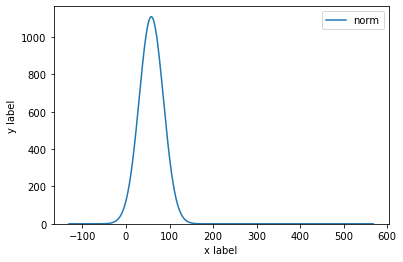

(             SSE distribution
 6   29220.382918         norm
 1   76751.952336       cauchy
 3  106878.241390      laplace
 4  156812.994821         levy
 7  226248.533340            t
 0  264902.882589        alpha
 2  311631.407703       cosine
 5  589623.998399       levy_l,
 'norm',
 (58.11224489795919, 27.73141934286734))

In [234]:
from tqdm import tqdm
def fit_scipy_distributions(array, bins, plot_hist = True, plot_best_fit = True, plot_all_fits = False):
    """
    Fits a range of Scipy's distributions (see scipy.stats) against an array-like input.
    Returns the sum of squared error (SSE) between the fits and the actual distribution.
    Can also choose to plot the array's histogram along with the computed fits.
    N.B. Modify the "CHANGE IF REQUIRED" comments!
    
    Input: array - array-like input
           bins - number of bins wanted for the histogram
           plot_hist - boolean, whether you want to show the histogram
           plot_best_fit - boolean, whether you want to overlay the plot of the best fitting distribution
           plot_all_fits - boolean, whether you want to overlay ALL the fits (can be messy!)
    
    Returns: results - dataframe with SSE and distribution name, in ascending order (i.e. best fit first)
             best_name - string with the name of the best fitting distribution
             best_params - list with the parameters of the best fitting distribution.
    """
    
    if plot_best_fit or plot_all_fits:
        assert plot_hist, "plot_hist must be True if setting plot_best_fit or plot_all_fits to True"
    
    # Returns un-normalised (i.e. counts) histogram
    y, x = np.histogram(np.array(array), bins=bins)
    
    # Some details about the histogram
    bin_width = x[1]-x[0]
    N = len(array)
    x_mid = (x + np.roll(x, -1))[:-1] / 2.0 # go from bin edges to bin middles
    
    # selection of available distributions
    # CHANGE THIS IF REQUIRED
    DISTRIBUTIONS = [st.alpha,st.cauchy,st.cosine,st.laplace,st.levy,st.levy_l,st.norm,st.t]

    if plot_hist:
        fig, ax = plt.subplots()
        h = ax.hist(np.array(array), bins = bins, color = 'w')

    # loop through the distributions and store the sum of squared errors
    # so we know which one eventually will have the best fit
    sses = []
    for dist in tqdm(DISTRIBUTIONS):
        name = dist.__class__.__name__[:-4]

        params = dist.fit(np.array(array))
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = dist.pdf(x_mid, loc=loc, scale=scale, *arg)
        pdf_scaled = pdf * bin_width * N # to go from pdf back to counts need to un-normalise the pdf

        sse = np.sum((y - pdf_scaled)**2)
        sses.append([sse, name])

        # Not strictly necessary to plot, but pretty patterns
        if plot_all_fits:
            ax.plot(x_mid, pdf_scaled, label = name)
    
    if plot_all_fits:
        plt.legend(loc=1)

    # CHANGE THIS IF REQUIRED
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')

    # Things to return - df of SSE and distribution name, the best distribution and its parameters
    results = pd.DataFrame(sses, columns = ['SSE','distribution']).sort_values(by='SSE') 
    best_name = results.iloc[0]['distribution']
    best_dist = getattr(st, best_name)
    best_params = best_dist.fit(np.array(array))
    
    if plot_best_fit:
        new_x = np.linspace(x_mid[0] - (bin_width * 2), x_mid[-1] + (bin_width * 2), 1000)
        best_pdf = best_dist.pdf(new_x, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
        best_pdf_scaled = best_pdf * bin_width * N
        ax.plot(new_x, best_pdf_scaled, label = best_name)
        plt.legend(loc=1)
    
    if plot_hist:
        plt.show()
    
    return results, best_name, best_params
fit_scipy_distributions(Y_train, bins=5)

#### Cruce

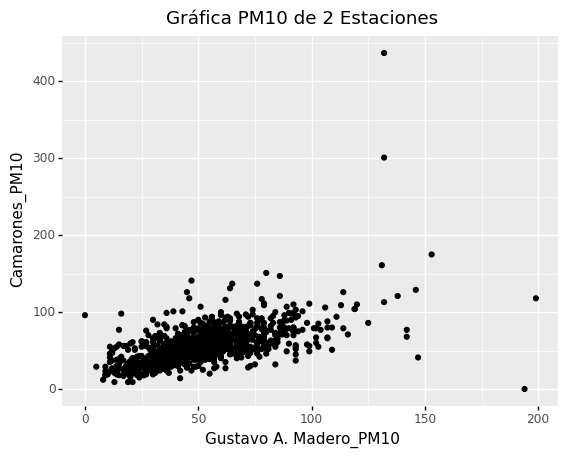

<ggplot: (8752922876465)>

In [30]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Gustavo A. Madero_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

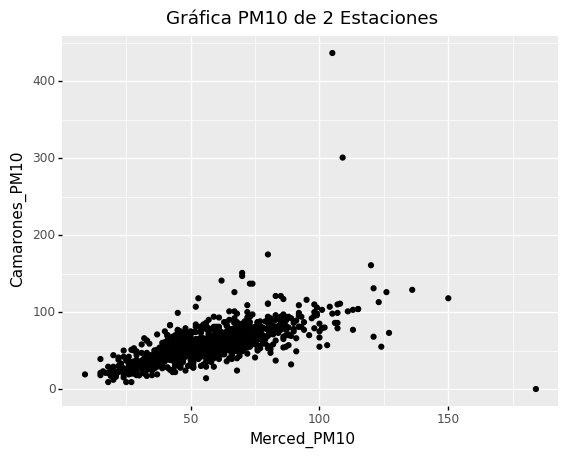

<ggplot: (8752922834733)>

In [31]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Merced_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

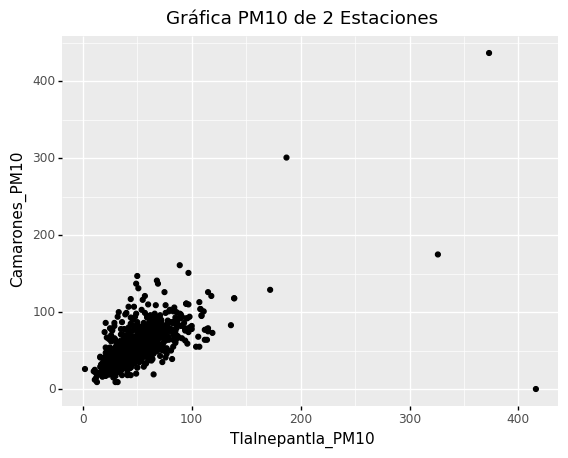

<ggplot: (8752922863333)>

In [32]:
(
    ggplot(camarones_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]) +
    geom_point(aes(x="Tlalnepantla_PM10", y="Camarones_PM10")) +
    labs(title="Gráfica PM10 de 2 Estaciones")
)

In [33]:
corr = camarones_train.filter(like="PM10", axis=1)[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)].corr()
corr

,Camarones_PM10,FES Acatlán_PM10,Gustavo A. Madero_PM10,Merced_PM10,Tlalnepantla_PM10
Camarones_PM10,1.000000,0.585749,0.576044,0.644909,0.636219
FES Acatlán_PM10,0.585749,1.000000,0.561326,0.595378,0.755438
Gustavo A. Madero_PM10,0.576044,0.561326,1.000000,0.781552,0.588582
Merced_PM10,0.644909,0.595378,0.781552,1.000000,0.599567
Tlalnepantla_PM10,0.636219,0.755438,0.588582,0.599567,1.000000


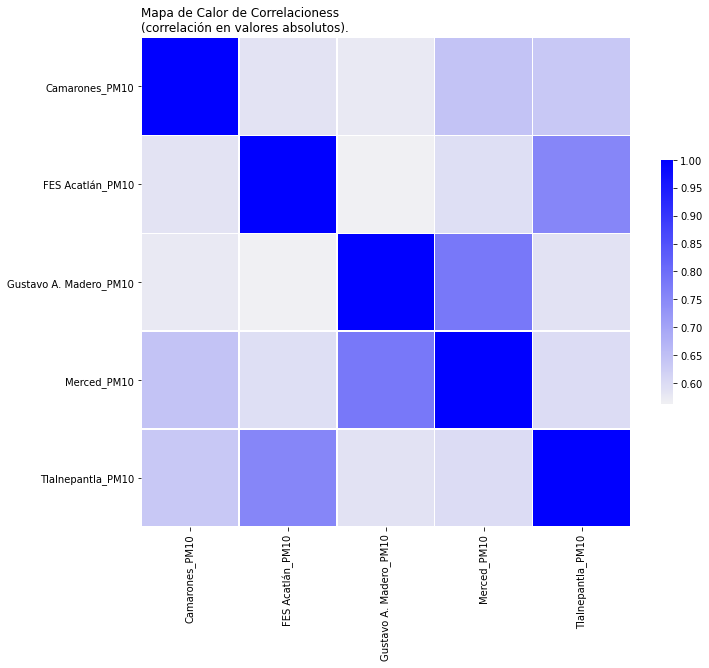

In [34]:
#corr = corr.loc[:, ["PM2.5", "PM10"]]
mask = None
#mask = np.triu(np.ones_like(corr*-1, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.palettes.blend_palette(["#ffffff", "#000055"], 
#                                  n_colors=16, 
#                                  as_cmap=True)
cmap = sns.color_palette("light:blue", as_cmap=True)

plt.title("Mapa de Calor de Correlacioness\n" +
          "(correlación en valores absolutos).", loc='left')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.xlabel("Variables Respuesta")
#plt.ylabel("Variables Predictoras")
plt.show()

In [35]:
corr = camarones_train.filter(like="Camarones", axis=1)[~camarones_train.filter(regex=r"Camarones", axis=1).isna().any(axis=1)].corr()
corr

,Camarones_CO,Camarones_NO,Camarones_NO2,Camarones_NOx,Camarones_O3,Camarones_PM10,Camarones_PM2.5,Camarones_SO2
Camarones_CO,1.000000,0.743399,0.770512,0.840918,-0.452770,0.298775,0.424494,0.103995
Camarones_NO,0.743399,1.000000,0.452126,0.968873,-0.430920,0.123757,0.202277,0.102433
Camarones_NO2,0.770512,0.452126,1.000000,0.658736,-0.557640,0.283317,0.434776,0.160174
Camarones_NOx,0.840918,0.968873,0.658736,1.000000,-0.517954,0.183213,0.291152,0.130837
Camarones_O3,-0.452770,-0.430920,-0.557640,-0.517954,1.000000,0.030740,0.005117,-0.194188
Camarones_PM10,0.298775,0.123757,0.283317,0.183213,0.030740,1.000000,0.612167,0.153458
Camarones_PM2.5,0.424494,0.202277,0.434776,0.291152,0.005117,0.612167,1.000000,0.290375
Camarones_SO2,0.103995,0.102433,0.160174,0.130837,-0.194188,0.153458,0.290375,1.000000


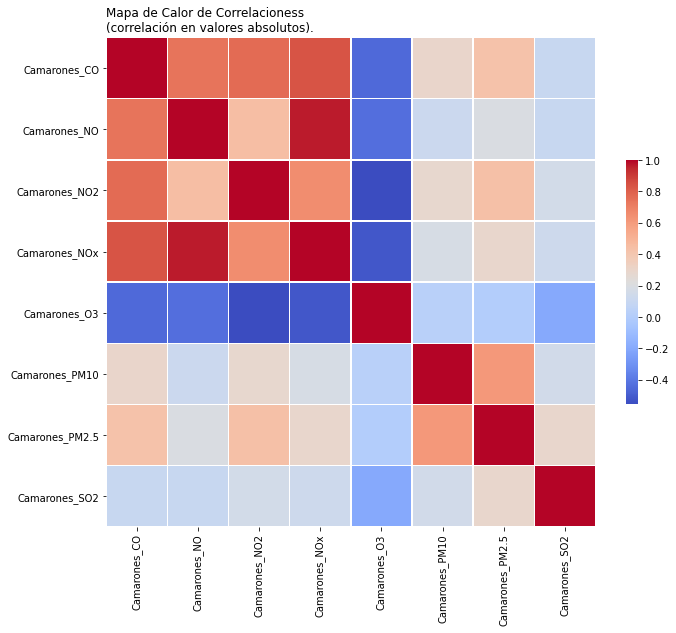

In [36]:
#corr = corr.loc[:, ["PM2.5", "PM10"]]
mask = None
#mask = np.triu(np.ones_like(corr*-1, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.palettes.blend_palette(["#ffffff", "#000055"], 
#                                  n_colors=16, 
#                                  as_cmap=True)
#cmap = sns.diverging_palette(250, 20, as_cmap=True)
cmap = sns.color_palette("coolwarm", as_cmap=True)

plt.title("Mapa de Calor de Correlacioness\n" +
          "(correlación en valores absolutos).", loc='left')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.xlabel("Variables Respuesta")
#plt.ylabel("Variables Predictoras")
plt.show()

#### PM2.5

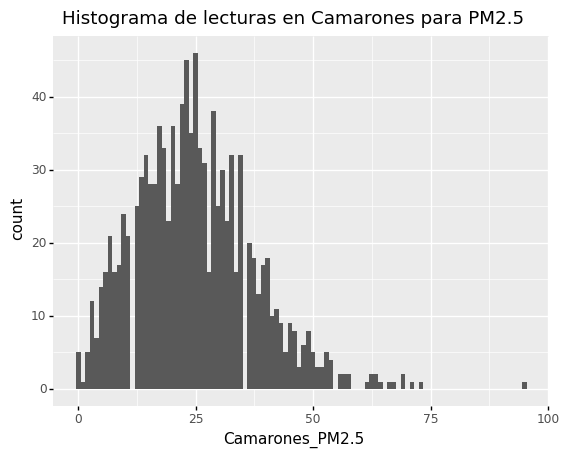

<ggplot: (8752963439053)>

In [37]:
(
    ggplot(camarones_train[["Camarones_PM2.5"]]) +
    geom_histogram(aes(x="Camarones_PM2.5"), bins=100) +
    labs(title="Histograma de lecturas en Camarones para PM2.5")
)

## Regresión Lineal

Removemos observaciones incompletas para realizar la regresión.

In [41]:
Y_train = camarones_train["Camarones_PM10"]
Y_test  = camarones_test["Camarones_PM10"]
X_train = camarones_train.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)
X_test = camarones_test.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)

X_train = camarones_train.filter(regex="(Merced|Tlalnepantla)")
X_test  = camarones_test.filter(regex="(Merced|Tlalnepantla)")

### Código para filtrar solo las columnas con PM10
### Es decir, estaciones que tienen el contaminante PM10
X_test = X_test.filter(regex=r"PM10", axis=1)
X_train = X_train.filter(regex=r"PM10", axis=1)

## Removemos observaciones incompletas
X_train = X_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
X_test = X_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_train = Y_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_test = Y_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]

In [42]:
reg = LinearRegression(n_jobs=8).fit(X_train, Y_train)
Yhat_train = reg.predict(X_train)
Yhat_test = reg.predict(X_test)

In [43]:
X_train.columns

Index(['Merced_PM10', 'Tlalnepantla_PM10'], dtype='object')

In [44]:
reg.coef_

array([0.53072702, 0.37388491])

In [45]:
reg.intercept_

8.488947860546723

In [46]:
r2_score(Y_train, Yhat_train)

0.5131358450122813

In [47]:
r2_score(Y_test, Yhat_test)

-0.4144452395742104

In [48]:
mean_squared_error(Y_train, Yhat_train)

374.41392923127256

In [49]:
mean_squared_error(Y_test, Yhat_test)

858.5768327522378

In [50]:
mean_absolute_error(Y_train, Yhat_train)

10.999394181631775

In [51]:
mean_absolute_error(Y_test, Yhat_test)

13.10422582517235

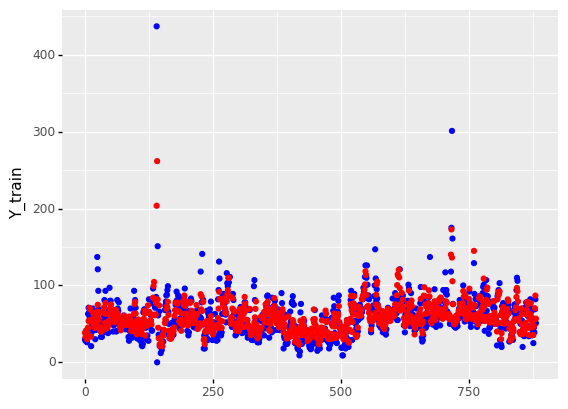

<ggplot: (8752922748573)>

In [52]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train,
        "Yhat_train": Yhat_train
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

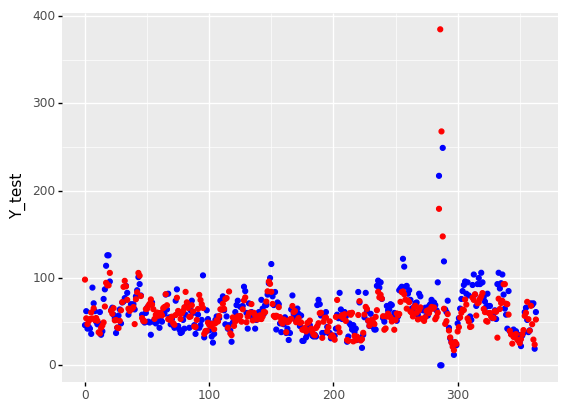

<ggplot: (8752922747601)>

In [53]:
(
    ggplot(pd.DataFrame({
        "Y_test": Y_test,
        "Yhat_test": Yhat_test
    })) +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Y_test"), color='blue') +
    geom_point(aes(x=range(0, Y_test.shape[0]), y="Yhat_test"), color='red')
)

## Lasso

In [139]:
Y_train = camarones_train["Camarones_PM10"]
Y_test  = camarones_test["Camarones_PM10"]
X_train = camarones_train.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)
X_test = camarones_test.filter(regex=r"^(?!Camarones_PM10|Fecha)", axis=1)

### Código para filtrar solo las columnas con PM10
### Es decir, estaciones que tienen el contaminante PM10
X_test = X_test.filter(regex=r"PM10", axis=1)
X_train = X_train.filter(regex=r"PM10", axis=1)

## Removemos observaciones incompletas
X_train = X_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
X_test = X_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_train = Y_train[~camarones_train.filter(regex=r"PM10", axis=1).isna().any(axis=1)]
Y_test = Y_test[~camarones_test.filter(regex=r"PM10", axis=1).isna().any(axis=1)]

In [140]:
reg = Lasso().fit(X_train, Y_train)
Yhat_train = reg.predict(X_train)
Yhat_test = reg.predict(X_test)

In [141]:
X_train.columns

Index(['FES Acatlán_PM10', 'Gustavo A. Madero_PM10', 'Merced_PM10',
       'Tlalnepantla_PM10'],
      dtype='object')

In [103]:
reg.coef_

array([0.09567696, 0.06840776, 0.4426    , 0.29441044])

In [104]:
reg.intercept_

9.366559256014888

In [105]:
r2_score(Y_train, Yhat_train)

0.5199968593721296

In [106]:
r2_score(Y_test, Yhat_test)

-0.1294304409086644

In [107]:
mean_squared_error(Y_train, Yhat_train)

369.1375922517144

In [108]:
mean_squared_error(Y_test, Yhat_test)

685.5711226128724

In [109]:
mean_absolute_error(Y_train, Yhat_train)

10.90154265031963

In [110]:
mean_absolute_error(Y_test, Yhat_test)

12.558248813984083

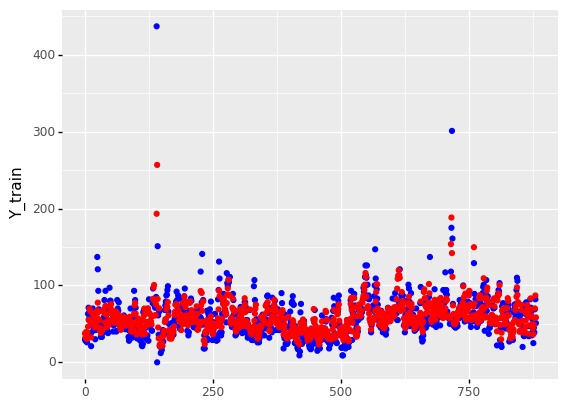

<ggplot: (8763794814273)>

In [111]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train,
        "Yhat_train": Yhat_train
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

## Regresión Lineal Bayesiana

Se utilizó Stan para realizar una aproximación de los datos que se distribuyen similar a una Poisson.

In [186]:
Yhat_train = pd.read_parquet("data/camarones_train_yhat-stan.parquet")
Yhat_train = Yhat_train["mean-all chains"]
Yhat_train.shape[0]

882

In [187]:
Y_train.shape[0]

882

In [188]:
r2_score(Y_train, Yhat_train)

-13.532854262847243

In [189]:
r2_score(Y_test, Yhat_test)

-0.4144452395742104

In [190]:
mean_squared_error(Y_train, Yhat_train)

11176.224439105285

In [191]:
mean_squared_error(Y_test, Yhat_test)

858.5768327522378

In [192]:
mean_absolute_error(Y_train, Yhat_train)

46.32515396825397

In [193]:
mean_absolute_error(Y_test, Yhat_test)

13.10422582517235

In [196]:
gdf = pd.concat({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train
    }, axis=1)[["Y_train", "Yhat_train"]]

gdf

,Y_train,Yhat_train
0,30.0,5.5089
1,28.0,4.3637
2,38.0,4.8390
3,35.0,5.3698
4,26.0,4.0612
...,...,...
877,45.0,23.4018
878,39.0,34.2782
879,69.0,65.9807
880,82.0,76.5296


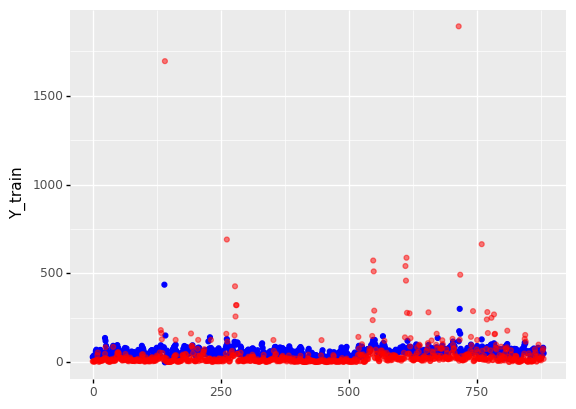

<ggplot: (8752795057089)>

In [214]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), 
               color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), 
               color='red', alpha=.5) 
)

## Media

In [101]:
Yhat_train = X_train.mean(axis=1)
Yhat_test = X_test.mean(axis=1)

In [102]:
mean_squared_error(Yhat_train, Y_train)

425.91850907029476

In [103]:
mean_squared_error(Yhat_test, Y_test)

581.5554601648352

In [104]:
mean_absolute_error(Yhat_train, Y_train)

12.331632653061224

In [105]:
mean_absolute_error(Yhat_test, Y_test)

13.761675824175825

## Modelos Generalizados de Regresión (GLM)



In [124]:
from sklearn.linear_model import PoissonRegressor
reg = PoissonRegressor(alpha=1e3)
reg_fit = reg.fit(X_train, Y_train)

In [125]:
Yhat_train_glm = reg_fit.predict(X_train)
(Yhat_train_glm.shape, Y_train.shape)

((882,), (882,))

In [126]:
Yhat_test_glm = reg_fit.predict(X_test)
(Yhat_test_glm.shape, Y_test.shape)

((364,), (364,))

In [127]:
mean_squared_error(Yhat_train_glm
                   , Y_train)

591.3427870326351

In [128]:
mean_squared_error(Yhat_test_glm, Y_test)

49388.29523509171

In [129]:
mean_absolute_error(Yhat_train_glm, Y_train)

12.428885298467446

In [130]:
mean_absolute_error(Yhat_test_glm, Y_test)

26.30284212406968

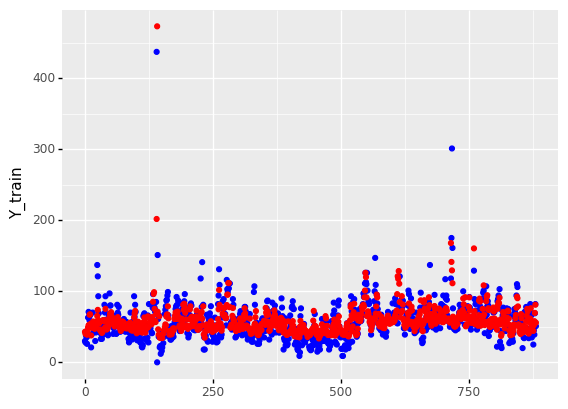

<ggplot: (8752818963393)>

In [132]:
(
    ggplot(pd.DataFrame({
        "Y_train": Y_train.reset_index(drop=True),
        "Yhat_train": Yhat_train_glm
    })) +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Y_train"), color='blue') +
    geom_point(aes(x=range(0, Y_train.shape[0]), y="Yhat_train"), color='red')
)

## Redes Neuronales

## Evaluación

## Conclusiones

## Referencias